In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


# Load Data

In [2]:
#make folder and unzip files
!mkdir stage1_train stage1_test
!unzip -qq ../input/data-science-bowl-2018/stage1_train_labels.csv.zip
!unzip -qq ../input/data-science-bowl-2018/stage1_train.zip -d stage1_train
!unzip -qq ../input/data-science-bowl-2018/stage1_test.zip -d stage1_test

In [3]:
# Import necessary modules and set global constants and variables. 

import tensorflow as tf            
import pandas as pd                 
import numpy as np                                       
import sklearn.model_selection     # For using KFold
import keras.preprocessing.image   # For using image generation
import datetime                    # To measure running time 
import skimage.transform           # For resizing images
import skimage.morphology          # For using image labeling
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
%matplotlib inline                  

# Global constants.
IMG_WIDTH = 256       # Default image width
IMG_HEIGHT = 256      # Default image height
IMG_CHANNELS = 3      # Default number of channels
CW_DIR = os.getcwd()  
TRAIN_DIR = os.path.join(CW_DIR, 'stage1_train') #path for train_folder dir
TEST_DIR = os.path.join(CW_DIR, 'stage1_test') #path for test_folder dir
IMG_TYPE = '.png'         # Image type
IMG_DIR_NAME = 'images'   # Folder name including the image
MASK_DIR_NAME = 'masks'   # Folder name including the masks
LOGS_DIR_NAME = 'logs'    # Folder name for TensorBoard summaries 
SAVES_DIR_NAME = 'saves'  # Folder name for storing network parameters
SEED = 123                # Random seed for splitting train/validation sets
    
# Global variables.
min_object_size = 1       # Minimal nucleous size in pixels
x_train = []
y_train = []
x_test = []
y_test_pred_proba = {}
y_test_pred = {}

# Display working/train/test directories.
print('CW_DIR = {}'.format(CW_DIR))
print('TRAIN_DIR = {}'.format(TRAIN_DIR))
print('TEST_DIR = {}'.format(TEST_DIR))

CW_DIR = /kaggle/working
TRAIN_DIR = /kaggle/working/stage1_train
TEST_DIR = /kaggle/working/stage1_test


In [4]:
# Collection of methods for data operations. Implemented are functions to read  
# images/masks from files and to read basic properties of the train/test data sets.

def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it.
    input: filepath=image file path from image folder
            target_size=resizing image become target_size
    output: img=image"""
    img = cv2.imread(filepath, color_mode) #read image
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA) #resize, interpolation
    return img

def read_mask(directory, target_size=None):
    """Read and resize masks contained in a given directory.
    input: directory=mask directory
            target size=size image that we want to set"""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask 

def read_train_data_properties(train_dir, img_dir_name, mask_dir_name):
    """Read basic properties of training images and masks"""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(train_dir))[1]):

        img_dir = os.path.join(train_dir, dir_name, img_dir_name)#dir for img_dir_name
        mask_dir = os.path.join(train_dir, dir_name, mask_dir_name) #dir for mask_dir_name
        num_masks = len(next(os.walk(mask_dir))[2])#len of image in mask dir
        img_name = next(os.walk(img_dir))[2][0]#getting img name
        img_name_id = os.path.splitext(img_name)[0]#split path text
        img_path = os.path.join(img_dir, img_name)#making path for image
        img_shape = read_image(img_path).shape #shape of image
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], num_masks,
                    img_path, mask_dir])

    train_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                            'img_ratio', 'num_channels', 
                                            'num_masks', 'image_path', 'mask_dir'])
    return train_df

def read_test_data_properties(test_dir, img_dir_name):
    """Read basic properties of test images."""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(test_dir))[1]):

        img_dir = os.path.join(test_dir, dir_name, img_dir_name)
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], img_path])

    test_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                           'img_ratio', 'num_channels', 'image_path'])
    return test_df

def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

def load_raw_data(image_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load raw data."""
    # Python lists to store the training images/masks and test images.
    x_train, y_train, x_test = [],[],[]

    # Read and resize train images/masks. 
    print('Loading and resizing train images and masks ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(train_df['image_path']), total=len(train_df)):
        img = read_image(train_df['image_path'].loc[i], target_size=image_size) #read image
        mask = read_mask(train_df['mask_dir'].loc[i], target_size=image_size) #read mask
        x_train.append(img)
        y_train.append(mask)

    # Read and resize test images. 
    print('Loading and resizing test images ...')
    sys.stdout.flush()
    sizes_test = []
    for i, filename in tqdm.tqdm(enumerate(test_df['image_path']), total=len(test_df)):
        img = read_image(test_df['image_path'].loc[i], target_size=image_size)
        sizes_test.append([img.shape[0], img.shape[1]])
        x_test.append(img)

    # Transform lists into 4-dim numpy arrays.
    x_train = np.array(x_train) #convert to numpy array
    y_train = np.expand_dims(np.array(y_train), axis=3) #expand dimension
    x_test = np.array(x_test)

    print('x_train.shape: {} of dtype {}'.format(x_train.shape, x_train.dtype))
    print('y_train.shape: {} of dtype {}'.format(y_train.shape, x_train.dtype))
    print('x_test.shape: {} of dtype {}'.format(x_test.shape, x_test.dtype))
    
    return x_train, y_train, x_test, sizes_test
    

In [5]:
# Basic properties of images/masks. 
train_df = read_train_data_properties(TRAIN_DIR, IMG_DIR_NAME, MASK_DIR_NAME)
test_df = read_test_data_properties(TEST_DIR, IMG_DIR_NAME)
print('train_df:')
print(train_df.describe())
print('')
print('test_df:')
print(test_df.describe())

train_df:
        img_height    img_width   img_ratio  num_channels   num_masks
count   670.000000   670.000000  670.000000         670.0  670.000000
mean    333.991045   378.500000    0.921008           3.0   43.971642
std     149.474845   204.838693    0.114294           0.0   47.962530
min     256.000000   256.000000    0.474057           3.0    1.000000
25%     256.000000   256.000000    0.800000           3.0   15.250000
50%     256.000000   320.000000    1.000000           3.0   27.000000
75%     360.000000   360.000000    1.000000           3.0   54.000000
max    1040.000000  1388.000000    1.000000           3.0  375.000000

test_df:
       img_height   img_width  img_ratio  num_channels
count   65.000000   65.000000  65.000000          65.0
mean   402.676923  393.184615   1.186171           3.0
std    129.082956  189.813386   0.631035           0.0
min    256.000000  161.000000   0.747126           3.0
25%    256.000000  256.000000   0.800000           3.0
50%    512.000000  2

In [6]:
train_df.head()

,img_id,img_height,img_width,img_ratio,num_channels,num_masks,image_path,mask_dir
0,bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7...,256,256,1.000000,3,44,/kaggle/working/stage1_train/bf566e75d5cb0196d...,/kaggle/working/stage1_train/bf566e75d5cb0196d...
1,b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d4...,520,696,0.747126,3,126,/kaggle/working/stage1_train/b1f23c4d27afed8af...,/kaggle/working/stage1_train/b1f23c4d27afed8af...
2,1b2bf5933b0fb82918d278983bee66e9532b53807c3638...,256,256,1.000000,3,11,/kaggle/working/stage1_train/1b2bf5933b0fb8291...,/kaggle/working/stage1_train/1b2bf5933b0fb8291...
3,da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db...,520,696,0.747126,3,140,/kaggle/working/stage1_train/da5f98f2b8a64eee7...,/kaggle/working/stage1_train/da5f98f2b8a64eee7...
4,c1afe66cd139f996fd984f5f2622903730ec2f1192d906...,256,320,0.800000,3,13,/kaggle/working/stage1_train/c1afe66cd139f996f...,/kaggle/working/stage1_train/c1afe66cd139f996f...


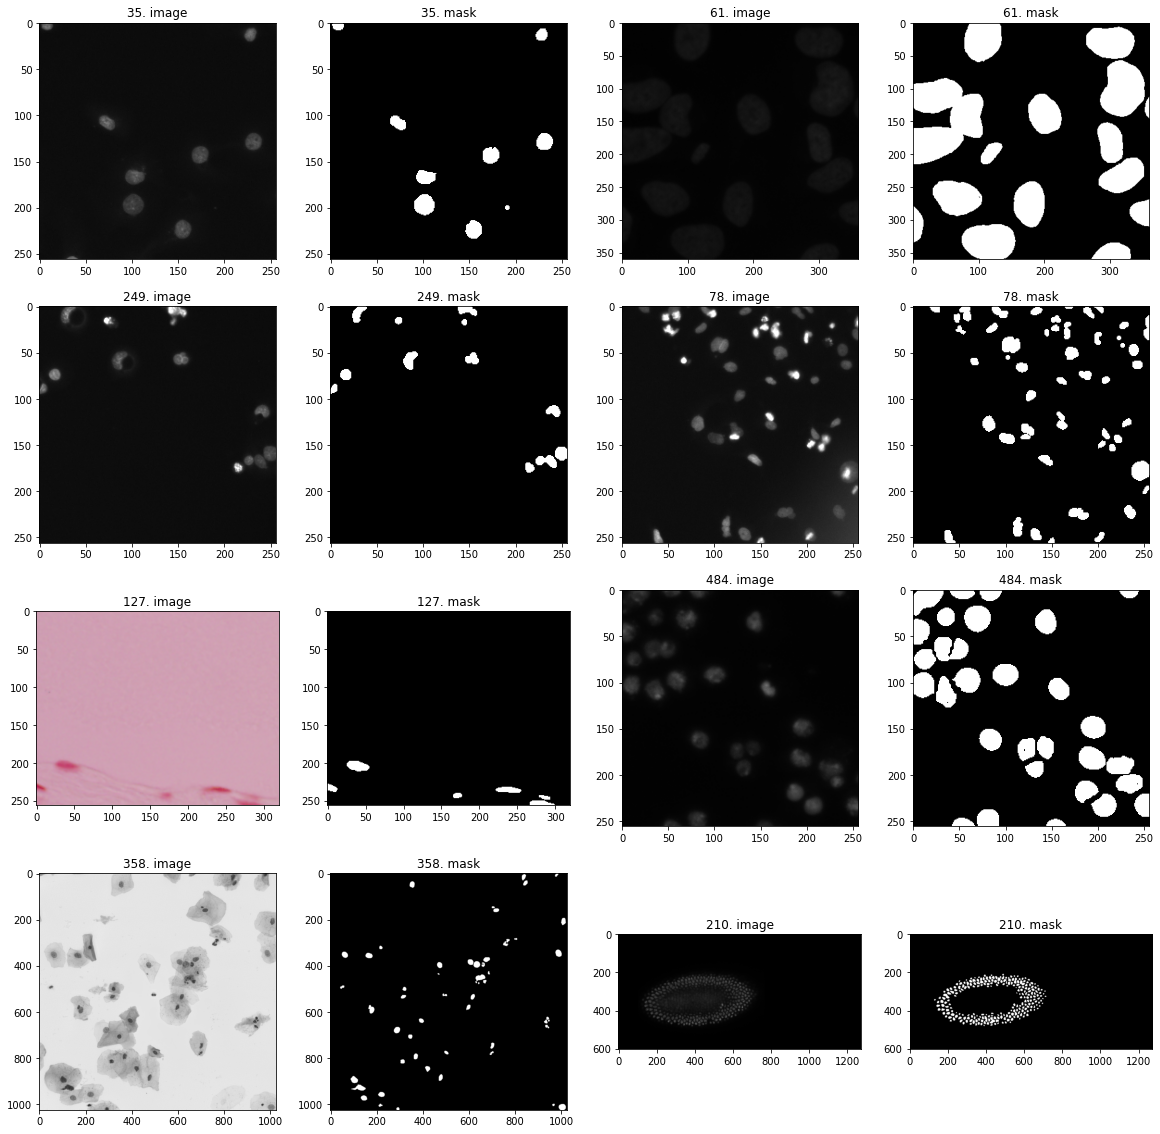

In [7]:
# Overview of train images/masks. There is a lot of variation concerning
# the form/size/number of nuclei and the darkness/lightness/colorfulness of 
# the images. 
fig, axs = plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(2):
        n = np.random.randint(0,len(train_df))
        axs[i,j*2].imshow(read_image(train_df['image_path'].loc[n]))
        axs[i,j*2].set_title('{}. image'.format(n))
        axs[i,j*2+1].imshow(read_mask(train_df['mask_dir'].loc[n]), cmap='gray') 
        axs[i,j*2+1].set_title('{}. mask'.format(n))       

as we can see, mask is black-white version of real image. 

In [8]:
# Read images/masks from files and resize them. Each image and mask 
# is stored as a 3-dim array where the number of channels is 3 and 1, respectively.
x_train, y_train, x_test, sizes_test = load_raw_data()

Loading and resizing train images and masks ...


100%|██████████| 670/670 [00:50<00:00, 13.35it/s]

Loading and resizing test images ...



100%|██████████| 65/65 [00:00<00:00, 141.67it/s]


x_train.shape: (670, 256, 256, 3) of dtype uint8
y_train.shape: (670, 256, 256, 1) of dtype uint8
x_test.shape: (65, 256, 256, 3) of dtype uint8


# Exploration Data Analysist

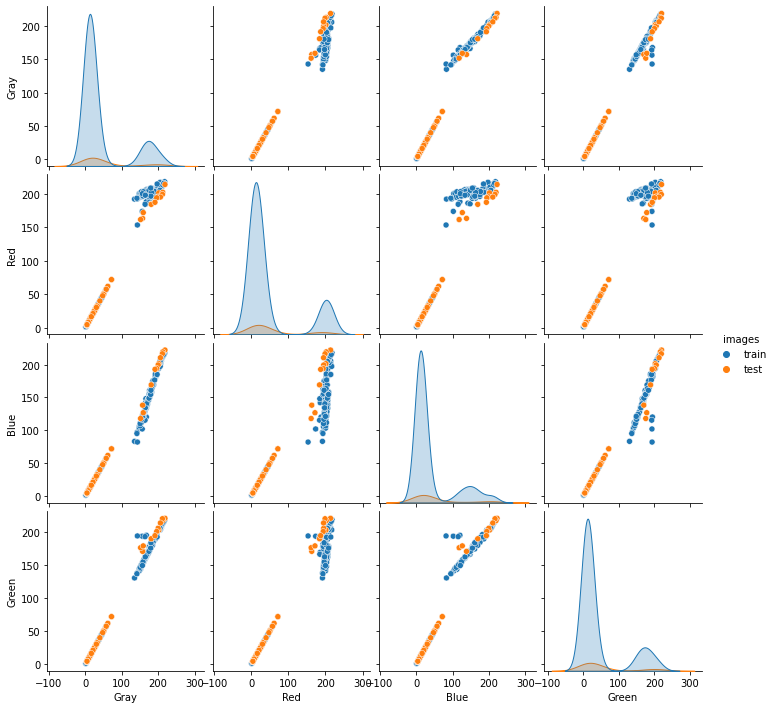

In [9]:
# Study the pixel intensity. On average the red, green and blue channels have similar
# intensities for all images. It should be noted that the background can be dark 
# (black) as  as well as light (white). 
def img_intensity_pairplot(x):
    """Plot intensity distributions of color channels."""
    df = pd.DataFrame()
    df['Gray'] = np.mean(x[:,:,:,:], axis=(1,2,3))
    if x.shape[3]==3:
        df['Red'] = np.mean(x[:,:,:,0], axis=(1,2))
        df['Blue'] = np.mean(x[:,:,:,1], axis=(1,2))
        df['Green'] = np.mean(x[:,:,:,2], axis=(1,2))
    return df

color_df = img_intensity_pairplot(np.concatenate([x_train, x_test]))
color_df['images'] = ['train']*len(x_train) + ['test']*len(x_test)
sns.pairplot(color_df, hue = 'images');

In first analysist we should read how are the intensity each channels. From the graphs,train images have more intensity than test images for every channels.There is something interesthing here. The intensity polarize between lower intensity and high intensity, we should normalize this intensity from [0:255] to [0:1]

In [10]:
# Collection of methods for basic data manipulation like normalizing, inverting, 
# color transformation and generating new images/masks

def normalize_imgs(data):
    """Normalize images."""
    return normalize(data, type_=1)

def normalize_masks(data):
    """Normalize masks."""
    return normalize(data, type_=1)
    
def normalize(data, type_=1): 
    """Normalize data."""
    if type_==0:
        # Convert pixel values from [0:255] to [0:1] by global factor
        data = data.astype(np.float32) / data.max()
    if type_==1:
        # Convert pixel values from [0:255] to [0:1] by local factor
        div = data.max(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        div[div < 0.01*data.mean()] = 1. # protect against too small pixel intensities
        data = data.astype(np.float32)/div
    if type_==2:
        # Standardisation of each image 
        data = data.astype(np.float32) / data.max() 
        mean = data.mean(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        std = data.std(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        data = (data-mean)/std

    return data

def trsf_proba_to_binary(y_data):
    """Transform propabilities into binary values 0 or 1."""  
    return np.greater(y_data,.5).astype(np.uint8)

def invert_imgs(imgs, cutoff=.5):
    '''Invert image if mean value is greater than cutoff.'''
    imgs = np.array(list(map(lambda x: 1.-x if np.mean(x)>cutoff else x, imgs)))
    return normalize_imgs(imgs)

def imgs_to_grayscale(imgs):
    '''Transform RGB images into grayscale spectrum.''' 
    if imgs.shape[3]==3:
        imgs = normalize_imgs(np.expand_dims(np.mean(imgs, axis=3), axis=3))
    return imgs

def generate_images(imgs, seed=None):
    """Generate new images."""
    # Transformations.
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 90., width_shift_range = 0.02 , height_shift_range = 0.02,
        zoom_range = 0.10, horizontal_flip=True, vertical_flip=True)
    
    # Generate new set of images
    imgs = image_generator.flow(imgs, np.zeros(len(imgs)), batch_size=len(imgs),
                                shuffle = False, seed=seed).next()    
    return imgs[0]

def generate_images_and_masks(imgs, masks):
    """Generate new images and masks."""
    seed = np.random.randint(10000) 
    imgs = generate_images(imgs, seed=seed)
    masks = trsf_proba_to_binary(generate_images(masks, seed=seed))
    return imgs, masks

def preprocess_raw_data(x_train, y_train, x_test, grayscale=False, invert=False):
    """Preprocessing of images and masks."""
    # Normalize images and masks
    x_train = normalize_imgs(x_train)
    y_train = trsf_proba_to_binary(normalize_masks(y_train))
    x_test = normalize_imgs(x_test)
    print('Images normalized.')
 
    if grayscale:
        # Remove color and transform images into grayscale spectrum.
        x_train = imgs_to_grayscale(x_train)
        x_test = imgs_to_grayscale(x_test)
        print('Images transformed into grayscale spectrum.')

    if invert:
        # Invert images, such that each image has a dark background.
        x_train = invert_imgs(x_train)
        x_test = invert_imgs(x_test)
        print('Images inverted to remove light backgrounds.')

    return x_train, y_train, x_test
    

In [11]:
# Normalize all images and masks. There is the possibility to transform images 
# into the grayscale sepctrum and to invert images which have a very 
# light background.
X_train, Y_train, X_test = preprocess_raw_data(x_train, y_train, x_test, invert=True)

Images normalized.
Images inverted to remove light backgrounds.


In [12]:
# Analyze nuclei sizes.
def get_nuclei_sizes():
    nuclei_sizes = []
    mask_idx = []
    for i in range(len(Y_train)):
        mask = Y_train[i].reshape(Y_train.shape[1], Y_train.shape[2])
        lab_mask = skimage.morphology.label(mask > .5)
        (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
        nuclei_sizes.extend(mask_sizes[1:])
        mask_idx.extend([i]*len(mask_sizes[1:]))
    return mask_idx, nuclei_sizes

mask_idx, nuclei_sizes = get_nuclei_sizes()
nuclei_sizes_df = pd.DataFrame()   
nuclei_sizes_df['mask_index'] = mask_idx
nuclei_sizes_df['nucleous_size'] = nuclei_sizes

print(nuclei_sizes_df.describe())
nuclei_sizes_df.sort_values(by='nucleous_size', ascending=True).head(10)

         mask_index  nucleous_size
count  23478.000000   23478.000000
mean     341.444799     260.183704
std      194.631466     430.462442
min        0.000000       1.000000
25%      161.000000      78.000000
50%      353.000000     132.000000
75%      507.000000     276.000000
max      669.000000   12064.000000


,mask_index,nucleous_size
7148,210,1
13625,402,1
21107,606,1
3620,98,1
19897,570,1
1277,38,1
17488,507,1
5767,159,1
4420,129,1
23239,665,1


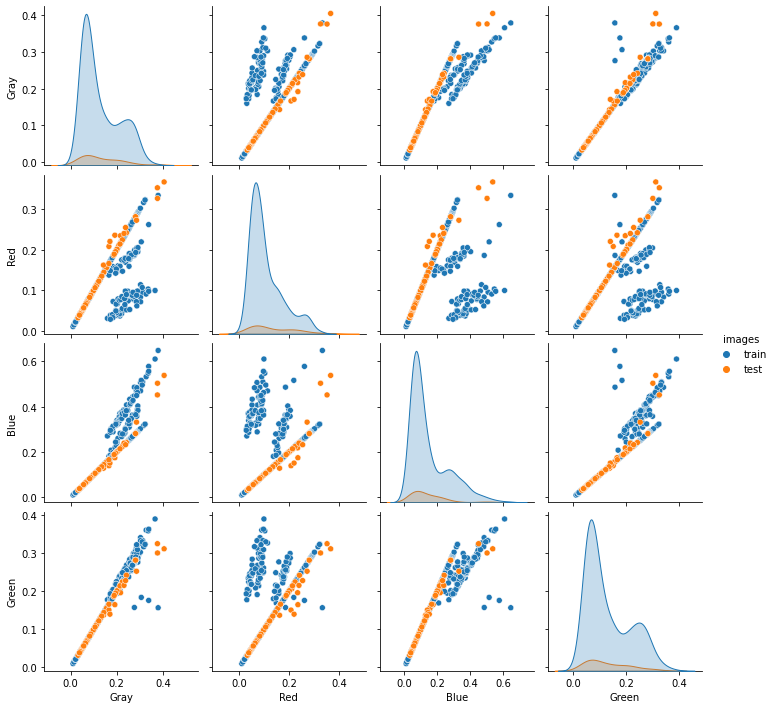

In [13]:
color_df = img_intensity_pairplot(np.concatenate([X_train, X_test]))
color_df['images'] = ['train']*len(X_train) + ['test']*len(X_test)
sns.pairplot(color_df, hue = 'images');

distribution intensity between train and test are same and there is no polarization of intensity. 

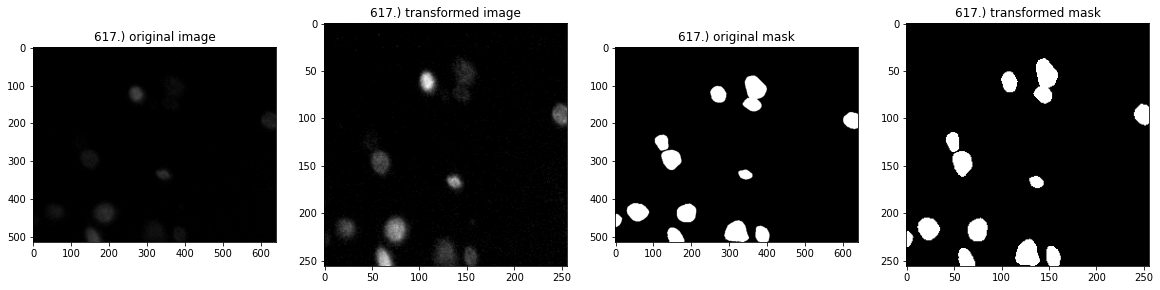

In [14]:
# Check the image transformation procedure (resizing, normalizing, inverting) 
# by looking at a sample. 
def img_comparison_plot(n):
    """Plot the original and transformed images/masks."""
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    axs[0].imshow(read_image(train_df['image_path'].loc[n]))
    axs[0].set_title('{}.) original image'.format(n))
    img, img_type = imshow_args(X_train[n])
    axs[1].imshow(img, img_type)
    axs[1].set_title('{}.) transformed image'.format(n))
    axs[2].imshow(read_mask(train_df['mask_dir'].loc[n]), cm.gray) 
    axs[2].set_title('{}.) original mask'.format(n))
    axs[3].imshow(Y_train[n,:,:,0], cm.gray)
    axs[3].set_title('{}.) transformed mask'.format(n));

n = 617 # np.random.randint(0, len(x_train))
img_comparison_plot(n)

After normalization, intensity of image is lighter than before and mask either. 

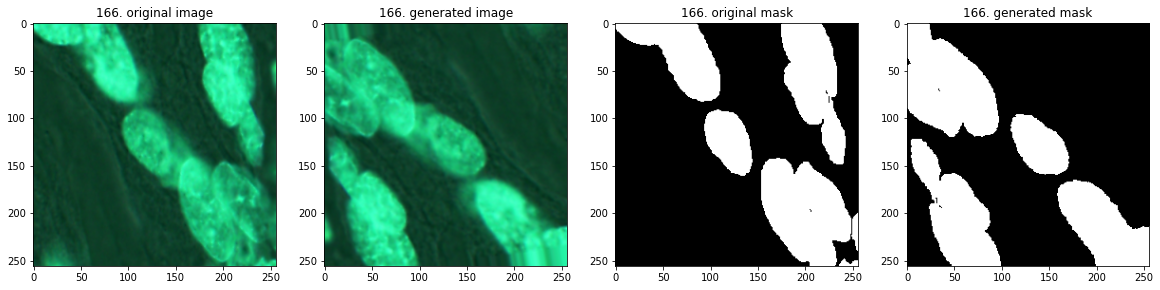

In [15]:
# Generate new images/masks via transformations applied on the original 
# images/maks. Data augmentations can be used for regularization.
def plot_generated_image_mask(n):
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    img_new, mask_new = generate_images_and_masks(X_train[n:n+1], Y_train[n:n+1])
    img, img_type = imshow_args(X_train[n])
    axs[0].imshow(img, img_type)
    axs[0].set_title('{}. original image'.format(n))
    img, img_type = imshow_args(img_new[0])
    axs[1].imshow(img, img_type)
    axs[1].set_title('{}. generated image'.format(n))
    axs[2].imshow(Y_train[n,:,:,0], cmap='gray')
    axs[2].set_title('{}. original mask'.format(n))
    axs[3].imshow(mask_new[0,:,:,0], cmap='gray')
    axs[3].set_title('{}. generated mask'.format(n));

n = 166 # np.random.randint(len(x_train))
plot_generated_image_mask(n)

In [16]:
""" Collection of methods to compute the score.

1. We start with a true and predicted mask, corresponding to one train image.

2. The true mask is segmented into different objects. Here lies a main source 
of error. Overlapping or touching nuclei are not separated but are labeled as 
one object. This means that the target mask can contain less objects than 
those that have been originally identified by humans.

3. In the same manner the predicted mask is segmented into different objects.

4. We compute all intersections between the objects of the true and predicted 
masks. Starting with the largest intersection area we assign true objects to 
predicted ones, until there are no true/pred objects left that overlap. 
We then compute for each true/pred object pair their corresponding intersection 
over union (iou) ratio. 

5. Given some threshold t we count the object pairs that have an iou > t, which
yields the number of true positives: tp(t). True objects that have no partner are 
counted as false positives: fp(t). Likewise, predicted objects without a counterpart
a counted as false negatives: fn(t).

6. Now, we compute the precision tp(t)/(tp(t)+fp(t)+fn(t)) for t=0.5,0.55,0.60,...,0.95
and take the mean value as the final precision (score).
"""

def get_labeled_mask(mask, cutoff=.5):
    """Object segmentation by labeling the mask."""
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    lab_mask = skimage.morphology.label(mask > cutoff) 
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
    
    return lab_mask  

def get_iou(y_true_labeled, y_pred_labeled):
    """Compute non-zero intersections over unions."""
    # Array of different objects and occupied area.
    (true_labels, true_areas) = np.unique(y_true_labeled, return_counts=True)
    (pred_labels, pred_areas) = np.unique(y_pred_labeled, return_counts=True)

    # Number of different labels.
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Each mask has at least one identified object.
    if (n_true_labels > 1) and (n_pred_labels > 1):
        
        # Compute all intersections between the objects.
        all_intersections = np.zeros((n_true_labels, n_pred_labels))
        for i in range(y_true_labeled.shape[0]):
            for j in range(y_true_labeled.shape[1]):
                m = y_true_labeled[i,j]
                n = y_pred_labeled[i,j]
                all_intersections[m,n] += 1 

        # Assign predicted to true background.
        assigned = [[0,0]]
        tmp = all_intersections.copy()
        tmp[0,:] = -1
        tmp[:,0] = -1

        # Assign predicted to true objects if they have any overlap.
        for i in range(1, np.min([n_true_labels, n_pred_labels])):
            mn = list(np.unravel_index(np.argmax(tmp), (n_true_labels, n_pred_labels)))
            if all_intersections[mn[0], mn[1]] > 0:
                assigned.append(mn)
            tmp[mn[0],:] = -1
            tmp[:,mn[1]] = -1
        assigned = np.array(assigned)

        # Intersections over unions.
        intersection = np.array([all_intersections[m,n] for m,n in assigned])
        union = np.array([(true_areas[m] + pred_areas[n] - all_intersections[m,n]) 
                           for m,n in assigned])
        iou = intersection / union

        # Remove background.
        iou = iou[1:]
        assigned = assigned[1:]
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]

        # Labels that are not assigned.
        true_not_assigned = np.setdiff1d(true_labels, assigned[:,0])
        pred_not_assigned = np.setdiff1d(pred_labels, assigned[:,1])
        
    else:
        # in case that no object is identified in one of the masks
        iou = np.array([])
        assigned = np.array([])
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]
        true_not_assigned = true_labels
        pred_not_assigned = pred_labels
        
    # Returning parameters.
    params = {'iou': iou, 'assigned': assigned, 'true_not_assigned': true_not_assigned,
             'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
             'pred_labels': pred_labels}
    return params

def get_score_summary(y_true, y_pred):
    """Compute the score for a single sample including a detailed summary."""
    
    y_true_labeled = get_labeled_mask(y_true)  
    y_pred_labeled = get_labeled_mask(y_pred)  
    
    params = get_iou(y_true_labeled, y_pred_labeled)
    iou = params['iou']
    assigned = params['assigned']
    true_not_assigned = params['true_not_assigned']
    pred_not_assigned = params['pred_not_assigned']
    true_labels = params['true_labels']
    pred_labels = params['pred_labels']
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    summary = []
    for i,threshold in enumerate(np.arange(0.5, 1.0, 0.05)):
        tp = np.sum(iou > threshold)
        fn = n_true_labels - tp
        fp = n_pred_labels - tp
        if (tp+fp+fn)>0: 
            prec = tp/(tp+fp+fn)
        else: 
            prec = 0
        summary.append([threshold, prec, tp, fp, fn])

    summary = np.array(summary)
    score = np.mean(summary[:,1]) # Final score.
    params_dict = {'summary': summary, 'iou': iou, 'assigned': assigned, 
                   'true_not_assigned': true_not_assigned, 
                   'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
                   'pred_labels': pred_labels, 'y_true_labeled': y_true_labeled,
                   'y_pred_labeled': y_pred_labeled}
    
    return score, params_dict

def get_score(y_true, y_pred):
    """Compute the score for a batch of samples."""
    scores = []
    for i in range(len(y_true)):
        score,_ = get_score_summary(y_true[i], y_pred[i])
        scores.append(score)
    return np.array(scores)

def plot_score_summary(y_true, y_pred):
    """Plot score summary for a single sample."""
    # Compute score and assign parameters.
    score, params_dict = get_score_summary(y_true, y_pred)
    
    assigned = params_dict['assigned']
    true_not_assigned = params_dict['true_not_assigned']
    pred_not_assigned = params_dict['pred_not_assigned']
    true_labels = params_dict['true_labels']
    pred_labels = params_dict['pred_labels']
    y_true_labeled = params_dict['y_true_labeled']
    y_pred_labeled = params_dict['y_pred_labeled']
    summary = params_dict['summary']

    n_assigned = len(assigned)
    n_true_not_assigned = len(true_not_assigned)
    n_pred_not_assigned = len(pred_not_assigned)
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Summary dataframe.
    summary_df = pd.DataFrame(summary,columns=['threshold','precision','tp','fp','fn'])
    print('Final score:', score)
    print(summary_df)

    # Plots.
    fig, axs = plt.subplots(2,3,figsize=(20,13))

    # True mask with true objects.
    img = y_true
    axs[0,0].imshow(img, cmap=cm.gray)
    axs[0,0].set_title('{}.) true mask: {} true objects'.format(n,train_df['num_masks'][n]))
    
    # True mask with identified objects.
    #img = np.zeros(y_true.shape)
    #img[y_true_labeled > 0.5] = 255
    img, img_type = imshow_args(y_true_labeled)
    axs[0,1].imshow(img, img_type)
    axs[0,1].set_title('{}.) true mask: {} objects identified'.format(n, n_true_labels))
    
    # Predicted mask with identified objects.
    #img = np.zeros(y_true.shape)
    #img[y_pred_labeled > 0.5] = 255
    img, img_type = imshow_args(y_pred_labeled)
    axs[0,2].imshow(img, img_type)
    axs[0,2].set_title('{}.) predicted mask: {} objects identified'.format(
        n, n_pred_labels))

    # Prediction overlap with true mask.
    img = np.zeros(y_true.shape)
    img[y_true > 0.5] = 100
    for i,j in assigned: img[(y_true_labeled == i) & (y_pred_labeled == j)] = 255
    axs[1,0].set_title('{}.) {} pred. overlaps (white) with true objects (gray)'.format(
        n,len(assigned)))
    axs[1,0].imshow(img, cmap='gray', norm=None)

    # Intersection over union.
    img = np.zeros(y_true.shape)
    img[(y_pred_labeled > 0) & (y_pred_labeled < 100)] = 100
    img[(y_true_labeled > 0) & (y_true_labeled < 100)] = 100
    for i,j in assigned: img[(y_true_labeled == i) & (y_pred_labeled == j)] = 255
    axs[1,1].set_title('{}.) {} intersections (white) over unions (gray)'.format(
        n, n_assigned))
    axs[1,1].imshow(img, cmap='gray');

    # False positives and false negatives.
    img = np.zeros(y_true.shape)
    for i in pred_not_assigned: img[(y_pred_labeled == i)] = 255
    for i in true_not_assigned: img[(y_true_labeled == i)] = 100
    axs[1,2].set_title('{}.) no threshold: {} fp (white), {} fn (gray)'.format(
        n, n_pred_not_assigned, n_true_not_assigned))
    axs[1,2].imshow(img, cmap='gray');

Final score: 0.3424242424242424
   threshold  precision   tp   fp   fn
0       0.50   0.500000  4.0  2.0  2.0
1       0.55   0.500000  4.0  2.0  2.0
2       0.60   0.500000  4.0  2.0  2.0
3       0.65   0.500000  4.0  2.0  2.0
4       0.70   0.500000  4.0  2.0  2.0
5       0.75   0.500000  4.0  2.0  2.0
6       0.80   0.333333  3.0  3.0  3.0
7       0.85   0.090909  1.0  5.0  5.0
8       0.90   0.000000  0.0  6.0  6.0
9       0.95   0.000000  0.0  6.0  6.0


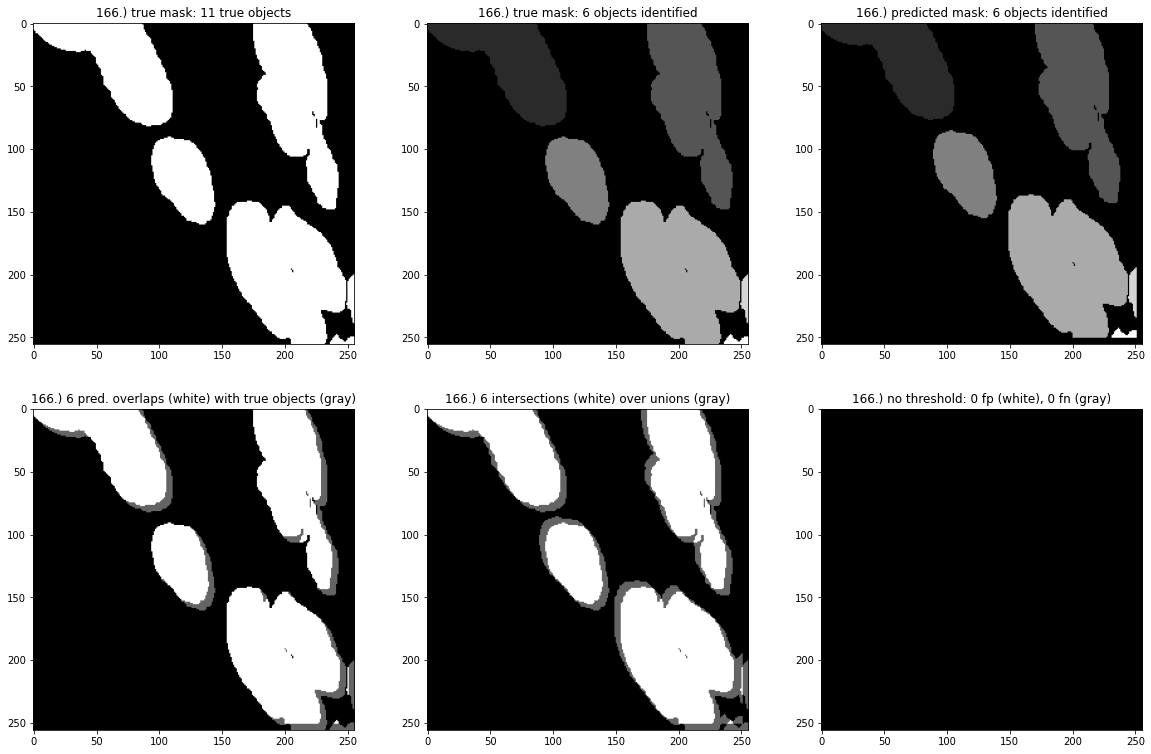

In [17]:
# Check the score metric for one sample. The predicted mask is simulated
# and can be modified in order to check the correct implementation of
# the score metric.
n = 166 # np.random.randint(len(x_train))
true_mask = Y_train[n,:,:,0].copy()
lab_true_mask = get_labeled_mask(true_mask)
pred_mask = true_mask.copy() # Create predicted mask from true mask.
true_mask[lab_true_mask == 7] = 0 # Remove one object => false postive
pred_mask[lab_true_mask == 10] = 0 # Remove one object => false negative
offset = 5  # Offset.
pred_mask = pred_mask[offset:, offset:]
pred_mask = np.pad(pred_mask, ((0, offset), (0, offset)), mode="constant")
plot_score_summary(true_mask, pred_mask) 

# Create Model

**U-Net architecture flow:**

![U-Net architecture flow:](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/u-net-architecture.png)

The main idea of this 'fully connected network' is to supplement a usual contracting network by successive layers, where pooling operators are replaced by upsampling operators. Hence, these layers (the right side of the 'U') **increase** the resolution of the output. 

*Excerpt* from [original paper:](https://arxiv.org/pdf/1505.04597.pdf) 

**Network Architecture**

The network architecture consists of a contracting path (left side) and an expansive path (right side). The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64- component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

*End excerpt.*



In [18]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda


def Unet(img_size):
    inputs = Input((img_size, img_size, 3))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    print('c1')
    c2 = Conv2D(32, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    print('c2')
    c3 = Conv2D(64, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    print('c3')
    c4 = Conv2D(128, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    print('c4')
    c5 = Conv2D(256, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c5)
    print('c5')
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c6)
    print('c6')
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c7)
    print('c7')
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c8)
    print('c8')
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='selu', kernel_initializer='he_normal', padding='same')(c9)
    print('c9')
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [19]:
from keras.preprocessing.image import ImageDataGenerator


def generator(xtr, xval, ytr, yval, batch_size):
    data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    image_datagen.fit(xtr, seed=10)
    mask_datagen.fit(ytr, seed=10)
    image_generator = image_datagen.flow(xtr, batch_size=batch_size, seed=10)
    mask_generator = mask_datagen.flow(ytr, batch_size=batch_size, seed=10)
    train_generator = zip(image_generator, mask_generator)

    val_gen_args = dict()
    image_datagen_val = ImageDataGenerator(**val_gen_args)
    mask_datagen_val = ImageDataGenerator(**val_gen_args)
    image_datagen_val.fit(xval, seed=10)
    mask_datagen_val.fit(yval, seed=10)
    image_generator_val = image_datagen_val.flow(xval, batch_size=batch_size, seed=10)
    mask_generator_val = mask_datagen_val.flow(yval, batch_size=batch_size, seed=10)
    val_generator = zip(image_generator_val, mask_generator_val)

    return train_generator, val_generator

In [20]:
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.losses import binary_crossentropy

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [21]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

# Training

for fit data, we use transformed data

In [22]:
import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split


if __name__ == "__main__":
    img_size = 256
    batch_size = 32
    train_path = './stage1_train'
    test_path = './stage1_test'
    
    #X_train, Y_train, X_test, sizes_test = make_df(train_path, test_path, img_size)
    #x_train, y_train, x_test = load_raw_data()
    xtr, xval, ytr, yval = train_test_split(X_train, Y_train, test_size=0.1, random_state=7)
    train_generator, val_generator = generator(xtr, xval, ytr, yval, batch_size)
    #print('imported')
    #print(xtr)
    model = Unet(img_size)
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy','mae'])
    print('going to model fit generator now')
    #model.fit_generator(train_generator, steps_per_epoch=len(xtr)/6, epochs=10,
    history=model.fit_generator(train_generator, steps_per_epoch=25, epochs=20,
                        validation_data=val_generator, validation_steps=len(xval)/batch_size)
    


2022-04-12 17:26:51.320165: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


c1
c2
c3
c4
c5
c6
c7
c8
c9
going to model fit generator now


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-12 17:26:52.466838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
25/25 [==============================] - 214s 8s/step - loss: 0.1073 - accuracy: 0.7366 - mae: 0.3302 - val_loss: -0.0856 - val_accuracy: 0.8777 - val_mae: 0.2439
Epoch 2/20
25/25 [==============================] - 207s 8s/step - loss: -0.3281 - accuracy: 0.8606 - mae: 0.1519 - val_loss: -0.5856 - val_accuracy: 0.9264 - val_mae: 0.0792
Epoch 3/20
25/25 [==============================] - 209s 8s/step - loss: -0.6730 - accuracy: 0.9256 - mae: 0.0603 - val_loss: -0.7312 - val_accuracy: 0.9513 - val_mae: 0.0525
Epoch 4/20
25/25 [==============================] - 207s 8s/step - loss: -0.7041 - accuracy: 0.9288 - mae: 0.0562 - val_loss: -0.7288 - val_accuracy: 0.9516 - val_mae: 0.0530
Epoch 5/20
25/25 [==============================] - 209s 8s/step - loss: -0.7113 - accuracy: 0.9287 - mae: 0.0552 - val_loss: -0.7287 - val_accuracy: 0.9535 - val_mae: 0.0513
Epoch 6/20
25/25 [==============================] - 207s 8s/step - loss: -0.7343 - accuracy: 0.9339 - mae: 0.0497 - val_loss: 

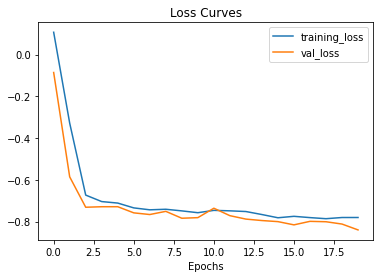

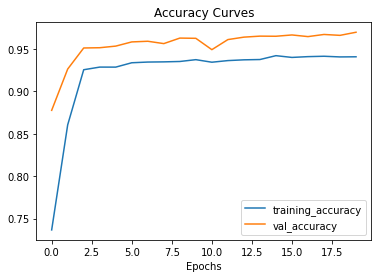

In [23]:
# Function for showing plot of model
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()
    
    

# Show the plot of model
plot_loss_curves(history)

# Submission

In [24]:
model.save('net_model.h5')

In [25]:
preds_test = model.predict(x_test, verbose=1)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(cv2.resize(preds_test[i], (sizes_test[i][1], sizes_test[i][0])))
        
test_ids = next(os.walk(test_path))[1]
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
        
        
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)

3/3 [==============================] - 5s 1s/step


# Reference

https://www.kaggle.com/code/mauddib/data-science-bowl-tutorial-using-cnn-tensorflow

https://www.kaggle.com/code/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352